# BERT English: Experiments across modality, time and country 

**Outline:**  
Experiment 1: BERT English (training on source data)   
Experiment 2: Across modality (evaluation on speeches)    
Experiment 3: Across time (evaluation on data > 2018)  
Experiment 4: Across country (evaluation per country)  

In [ ]:
# save results in...
path_results = './drive/MyDrive/Paper BERT/results/01b_BERT English/2023-04-05'

# Experiment 1: 
**Training data:** extracted data from Manifest project (version 2018-2) with the 7 English speaking countries from the paper by Osnabrügge ("Australia", "Canada", "Ireland", "New Zealand", "United Kingdom", "United States", "South Africa") 
**Testing data:** random test split  
**Models:** DistilBERT which is then compared to TF-IDF + LR (baseline) and BERT  
**Result:** DistilBaERT as best model (better as TF-IDF from paper, faster as BERT with similar performance)



## Loading the packages, functions and dataset

In [ ]:
# Load google drive. 
# Note: Working directory might need to be changed if run on your computer.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 106.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.6 MB/s eta 0:00:00


In [ ]:
# set wroking directory
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Paper BERT/notebooks')
from BERT_utils import *

In [ ]:
# set seeds for reproducibility
transformers.set_seed(3)
transformers.enable_full_determinism(3)
np.random.seed(3)

In [ ]:
# load data
path_file = './drive/MyDrive/Paper BERT/data/multilingual_data_2018-2.csv'
data = pd.read_csv(path_file,  index_col=None)

# ensure variables as string
data['topic_8'] = data['topic_8'].astype(str) # categories
data['text'] = data['text'].astype(str) # topic

Select English speaking countries: Australia, Canada, Ireland, New Zealand, South Africa, the United Kingdom (UK) and the United States (USA) and language english (e.g. in Canada French is also official national language)

In [ ]:
# select English speaking countries
countries = ["Australia", "Canada", "Ireland", "New Zealand", "United Kingdom", "United States", "South Africa"]
data_english = data.loc[data['countryname'].isin(countries), :]
data_english = data_english.loc[data_english['language'] =="english", :]
print(data_english.shape)
data_english.head(3) 
# note: BA also 114,523 observations

(114523, 7)


,countryname,text,language,code,document_index,date,topic_8
512801,United Kingdom,We face three connected crises: Healing the pl...,english,416.0,1,201505,economy
512802,United Kingdom,"Creating a more equal society, reversing the t...",english,503.0,1,201505,welfare and quality of life
512803,United Kingdom,Creating truly democratic central and local go...,english,202.0,1,201505,freedom and democracy


## Train-Test-Validation data sets

In [ ]:
# X: text, Y: topic
X = data_english['text'] 
Y = data_english['topic_8']

# Y numeric
Y_numeric = pd.factorize(Y)[0]
classes = pd.factorize(Y)[1]

# mapping: numeric -> category
dic_y_mapping = {n:label for n,label in enumerate(classes)}

# reverese mapping: catgory -> numeric
dic_y_mapping_inverse = dict(map(reversed, dic_y_mapping.items()))
dic_y_mapping_inverse

# test-train-validation split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_numeric, train_size=.8, random_state=77)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, train_size=0.5, random_state=77)

# overview splits
print('X', X.shape)
print('X_train', X_train.shape, round(X_train.shape[0]/X.shape[0], 2))
print('X_test', X_test.shape, round(X_test.shape[0]/X.shape[0], 2))
print('X_val', X_val.shape, round(X_val.shape[0]/X.shape[0], 2))

X (114523,)
X_train (91618,) 0.8
X_test (11452,) 0.1
X_val (11453,) 0.1


In [ ]:
# create same split for country variable for evaluation per country
country = data_english['countryname']
X_train, X_test, country_train , country_test  = train_test_split(X, country, train_size=.8, random_state=77)
X_test, X_val, country_test, country_val = train_test_split(X_test, country_test, train_size=0.5, random_state=77)

In [ ]:
# create dataset for training
dataset = {'train':Dataset.from_dict({'label':Y_train,'text':X_train}),
     'validation':Dataset.from_dict({'label':Y_val,'text':X_val}),
     'test':Dataset.from_dict({'label':Y_test,'text':X_test})
     }
dataset = DatasetDict(dataset)

# structure data set
print(dataset)

# example
dataset["train"][0]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 91618
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 11453
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 11452
    })
})


{'label': 1,
 'text': 'Labor will make the targeted, needs-based investments we need to give every Tasmanian student the chance to reach their potential and get ahead in the knowledge economy and job market.'}

## Preprocessing the data

In [ ]:
# Chose model and corresponing tokenize
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
batch_size = 16

In [ ]:
# Example toxenizer
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [101, 8667, 117, 1142, 1141, 5650, 106, 102, 1262, 1142, 5650, 2947, 1114, 1122, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# Encode data set
def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True)
# Note truncation=True: input truncated to the maximum length accepted by the model

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset

Map:   0%|          | 0/91618 [00:00<?, ? examples/s]

Map:   0%|          | 0/11453 [00:00<?, ? examples/s]

Map:   0%|          | 0/11452 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 91618
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11453
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11452
    })
})

## Fine-tuning the model

Fine-tuning with huggingface trainer: https://huggingface.co/transformers/v3.0.2/main_classes/trainer.html

In [ ]:
metric = load_metric('f1')
metric_name = "f1"
num_labels = 8
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
model_name = model_checkpoint.split("/")[-1]

<ipython-input-14-47b4617a7a88>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('f1')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    seed=0,
    #push_to_hub=True,
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.962400,0.937530,0.550951
2,0.776100,0.890005,0.574959
3,0.570400,0.955619,0.577979


TrainOutput(global_step=17181, training_loss=0.7930906218176885, metrics={'train_runtime': 4234.8538, 'train_samples_per_second': 64.903, 'train_steps_per_second': 4.057, 'total_flos': 6920610837807168.0, 'train_loss': 0.7930906218176885, 'epoch': 3.0})

In [ ]:
# https://www.thepythoncode.com/article/finetuning-bert-using-huggingface-transformers-python
# saving the fine tuned model & tokenizer
model_path = path_results + "/model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('./drive/MyDrive/Paper BERT/results/01b_BERT English/2023-04-05/model/tokenizer_config.json',
 './drive/MyDrive/Paper BERT/results/01b_BERT English/2023-04-05/model/special_tokens_map.json',
 './drive/MyDrive/Paper BERT/results/01b_BERT English/2023-04-05/model/vocab.txt',
 './drive/MyDrive/Paper BERT/results/01b_BERT English/2023-04-05/model/added_tokens.json',
 './drive/MyDrive/Paper BERT/results/01b_BERT English/2023-04-05/model/tokenizer.json')

## Evaluation

### Evaluation on training

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset["train"])

{'eval_loss': 0.3983985185623169,
 'eval_f1': 0.7638818220281025,
 'eval_runtime': 368.5835,
 'eval_samples_per_second': 248.568,
 'eval_steps_per_second': 15.538,
 'epoch': 3.0}

In [ ]:
def predict_BERT(encoded_dataset, dic_y_mapping, Y_train):
  #https://discuss.huggingface.co/t/different-results-predicting-from-trainer-and-model/12922/4
  #https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b
  # Make prediction
  raw_pred, _, _ = trainer.predict(encoded_dataset)

  # Preprocess raw predictions
  Y_pred = np.argmax(raw_pred, axis=1)

  # prediction
  Y_pred = [dic_y_mapping[y_train] for y_train in Y_pred]
  Y_pred = np.array(Y_pred, dtype= 'object')

  # true values
  Y_classes = [dic_y_mapping[y_train] for y_train in Y_train]
  Y_classes = np.array(Y_classes, dtype= 'object')
  return Y_pred, Y_classes


In [ ]:
Y_pred_training, Y_train_classes = predict_BERT(encoded_dataset["train"], dic_y_mapping, Y_train)
evaluation_training = evaluation_table(Y_train_classes,  Y_pred_training, domain= 'within-domain', data_description ="training")
evaluation_training 

,metric,score,domain,data
0,Accuracy,0.872852,within-domain,training
1,F1 score (macro),0.763882,within-domain,training


### Evaluation on validation data

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset["validation"])

{'eval_loss': 0.9556185603141785,
 'eval_f1': 0.5779785574005041,
 'eval_runtime': 45.9566,
 'eval_samples_per_second': 249.213,
 'eval_steps_per_second': 15.58,
 'epoch': 3.0}

### Evaluation on test set

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset["test"])

{'eval_loss': 0.965142548084259,
 'eval_f1': 0.5840978290755438,
 'eval_runtime': 46.8671,
 'eval_samples_per_second': 244.351,
 'eval_steps_per_second': 15.277,
 'epoch': 3.0}

In [ ]:
# get predictions and evaluation metrices
Y_pred_testing, Y_test_classes = predict_BERT(encoded_dataset["test"], dic_y_mapping, Y_test)
evaluation_testing = evaluation_table(Y_test_classes, Y_pred_testing, domain= 'within-domain', data_description ="testing")
evaluation_testing 

,metric,score,domain,data
0,Accuracy,0.697695,within-domain,testing
1,F1 score (macro),0.584098,within-domain,testing


Accuracy: 0.7
Detail:


,precision,recall,f1-score,support,data
economy,0.741002,0.760442,0.750596,2897.0,testing
external relations,0.761580,0.771034,0.766278,725.0,testing
fabric of society,0.662853,0.682104,0.672340,1274.0,testing
freedom and democracy,0.612284,0.563604,0.586937,566.0,testing
no topic,0.333333,0.009804,0.019048,102.0,testing
political system,0.583832,0.491597,0.533759,1190.0,testing
social groups,0.579913,0.583993,0.581946,1137.0,testing
welfare and quality of life,0.741430,0.783488,0.761879,3561.0,testing


<Figure size 640x480 with 0 Axes>

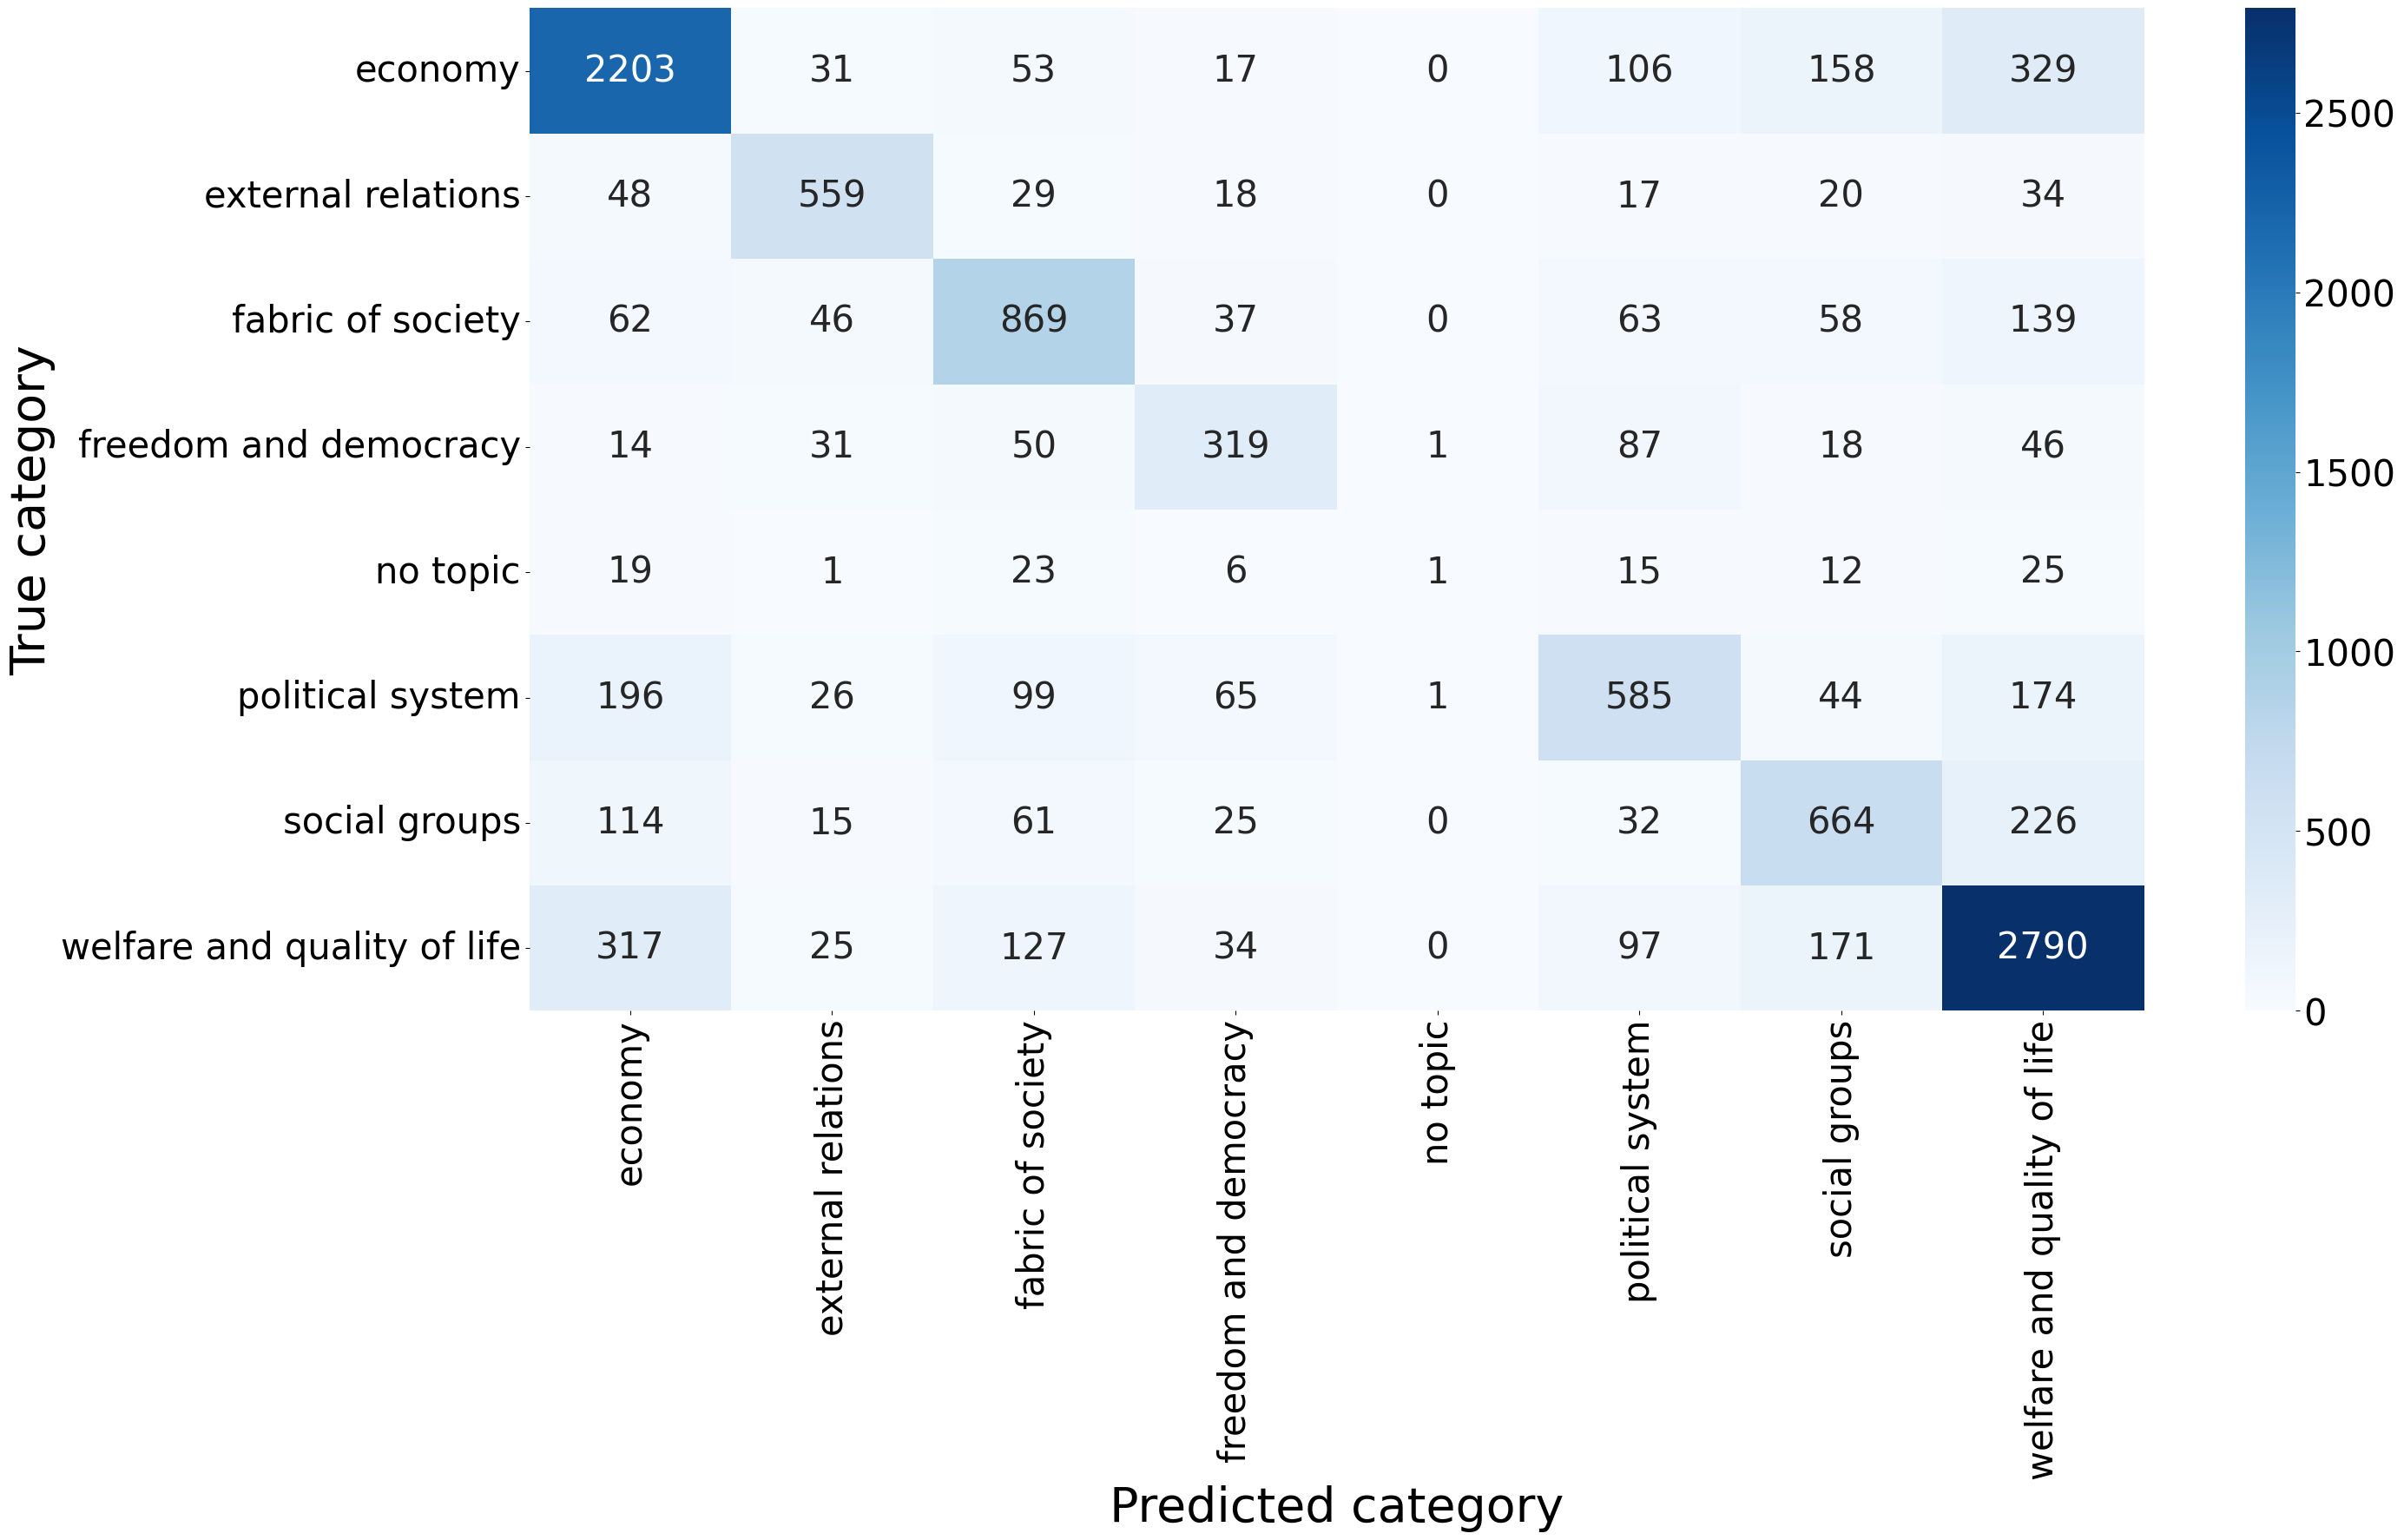

In [ ]:
classification_report_testing = evaluation_per_category(Y_test_classes, Y_pred_testing, data_description ="testing", path_results = path_results, figsize=(30,15))
classification_report_testing

# Experiment 2: 
**Testing data:** speeches from paper   
**Models:** fine-tuend BERT (on data from Manifest project, version 2018-2)  
**Result:** transfer across modality works well 

## Evaluation on target set

In [ ]:
# load data
path_file = './drive/MyDrive/Paper BERT/data/target_data.csv'
data_target = pd.read_csv(path_file,  index_col=None, sep = ';')

# ensure variables as string
data_target['topic_8'] = data_target['topic_8'].astype(str) # categories
data_target['text'] = data_target['text'].astype(str) # topic

# X: text, Y: topic
X_target = data_target['text'] 
Y_target = data_target['topic_8']

# show data
data_target.head(3)

,topic_8,text
0,welfare and quality of life,In the light of Mr Kelly's statements to the m...
1,external relations,Will New Zealand send further assistance to Fi...
2,welfare and quality of life,"There are many programmes out there, and there..."


In [ ]:
# target data numeric 
Y_target_numeric = [dic_y_mapping_inverse[y_test] for y_test in Y_target]
Y_target_numeric = np.array(Y_target_numeric, dtype= 'object')
Y_target_numeric

array([1, 5, 1, ..., 0, 2, 1], dtype=object)

In [ ]:
# create dataset 
dataset = {'target':Dataset.from_dict({'label':Y_target_numeric,'text':X_target})}
dataset_target = DatasetDict(dataset)
encoded_dataset_target = dataset_target.map(preprocess_function, batched=True)
encoded_dataset_target

Map:   0%|          | 0/4165 [00:00<?, ? examples/s]

DatasetDict({
    target: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4165
    })
})

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset_target["target"])

{'eval_loss': 1.354720115661621,
 'eval_f1': 0.5045830995191365,
 'eval_runtime': 139.2387,
 'eval_samples_per_second': 29.913,
 'eval_steps_per_second': 1.874,
 'epoch': 3.0}

In [ ]:
Y_pred_target, Y_target_classes = predict_BERT(encoded_dataset_target["target"], dic_y_mapping, Y_target_numeric)
evaluation_target = evaluation_table(Y_target,Y_pred_target, domain= 'cross-domain', data_description ="target")
evaluation_target

,metric,score,domain,data
0,Accuracy,0.561345,cross-domain,target
1,F1 score (macro),0.504583,cross-domain,target


Accuracy: 0.56
Detail:


<Figure size 640x480 with 0 Axes>

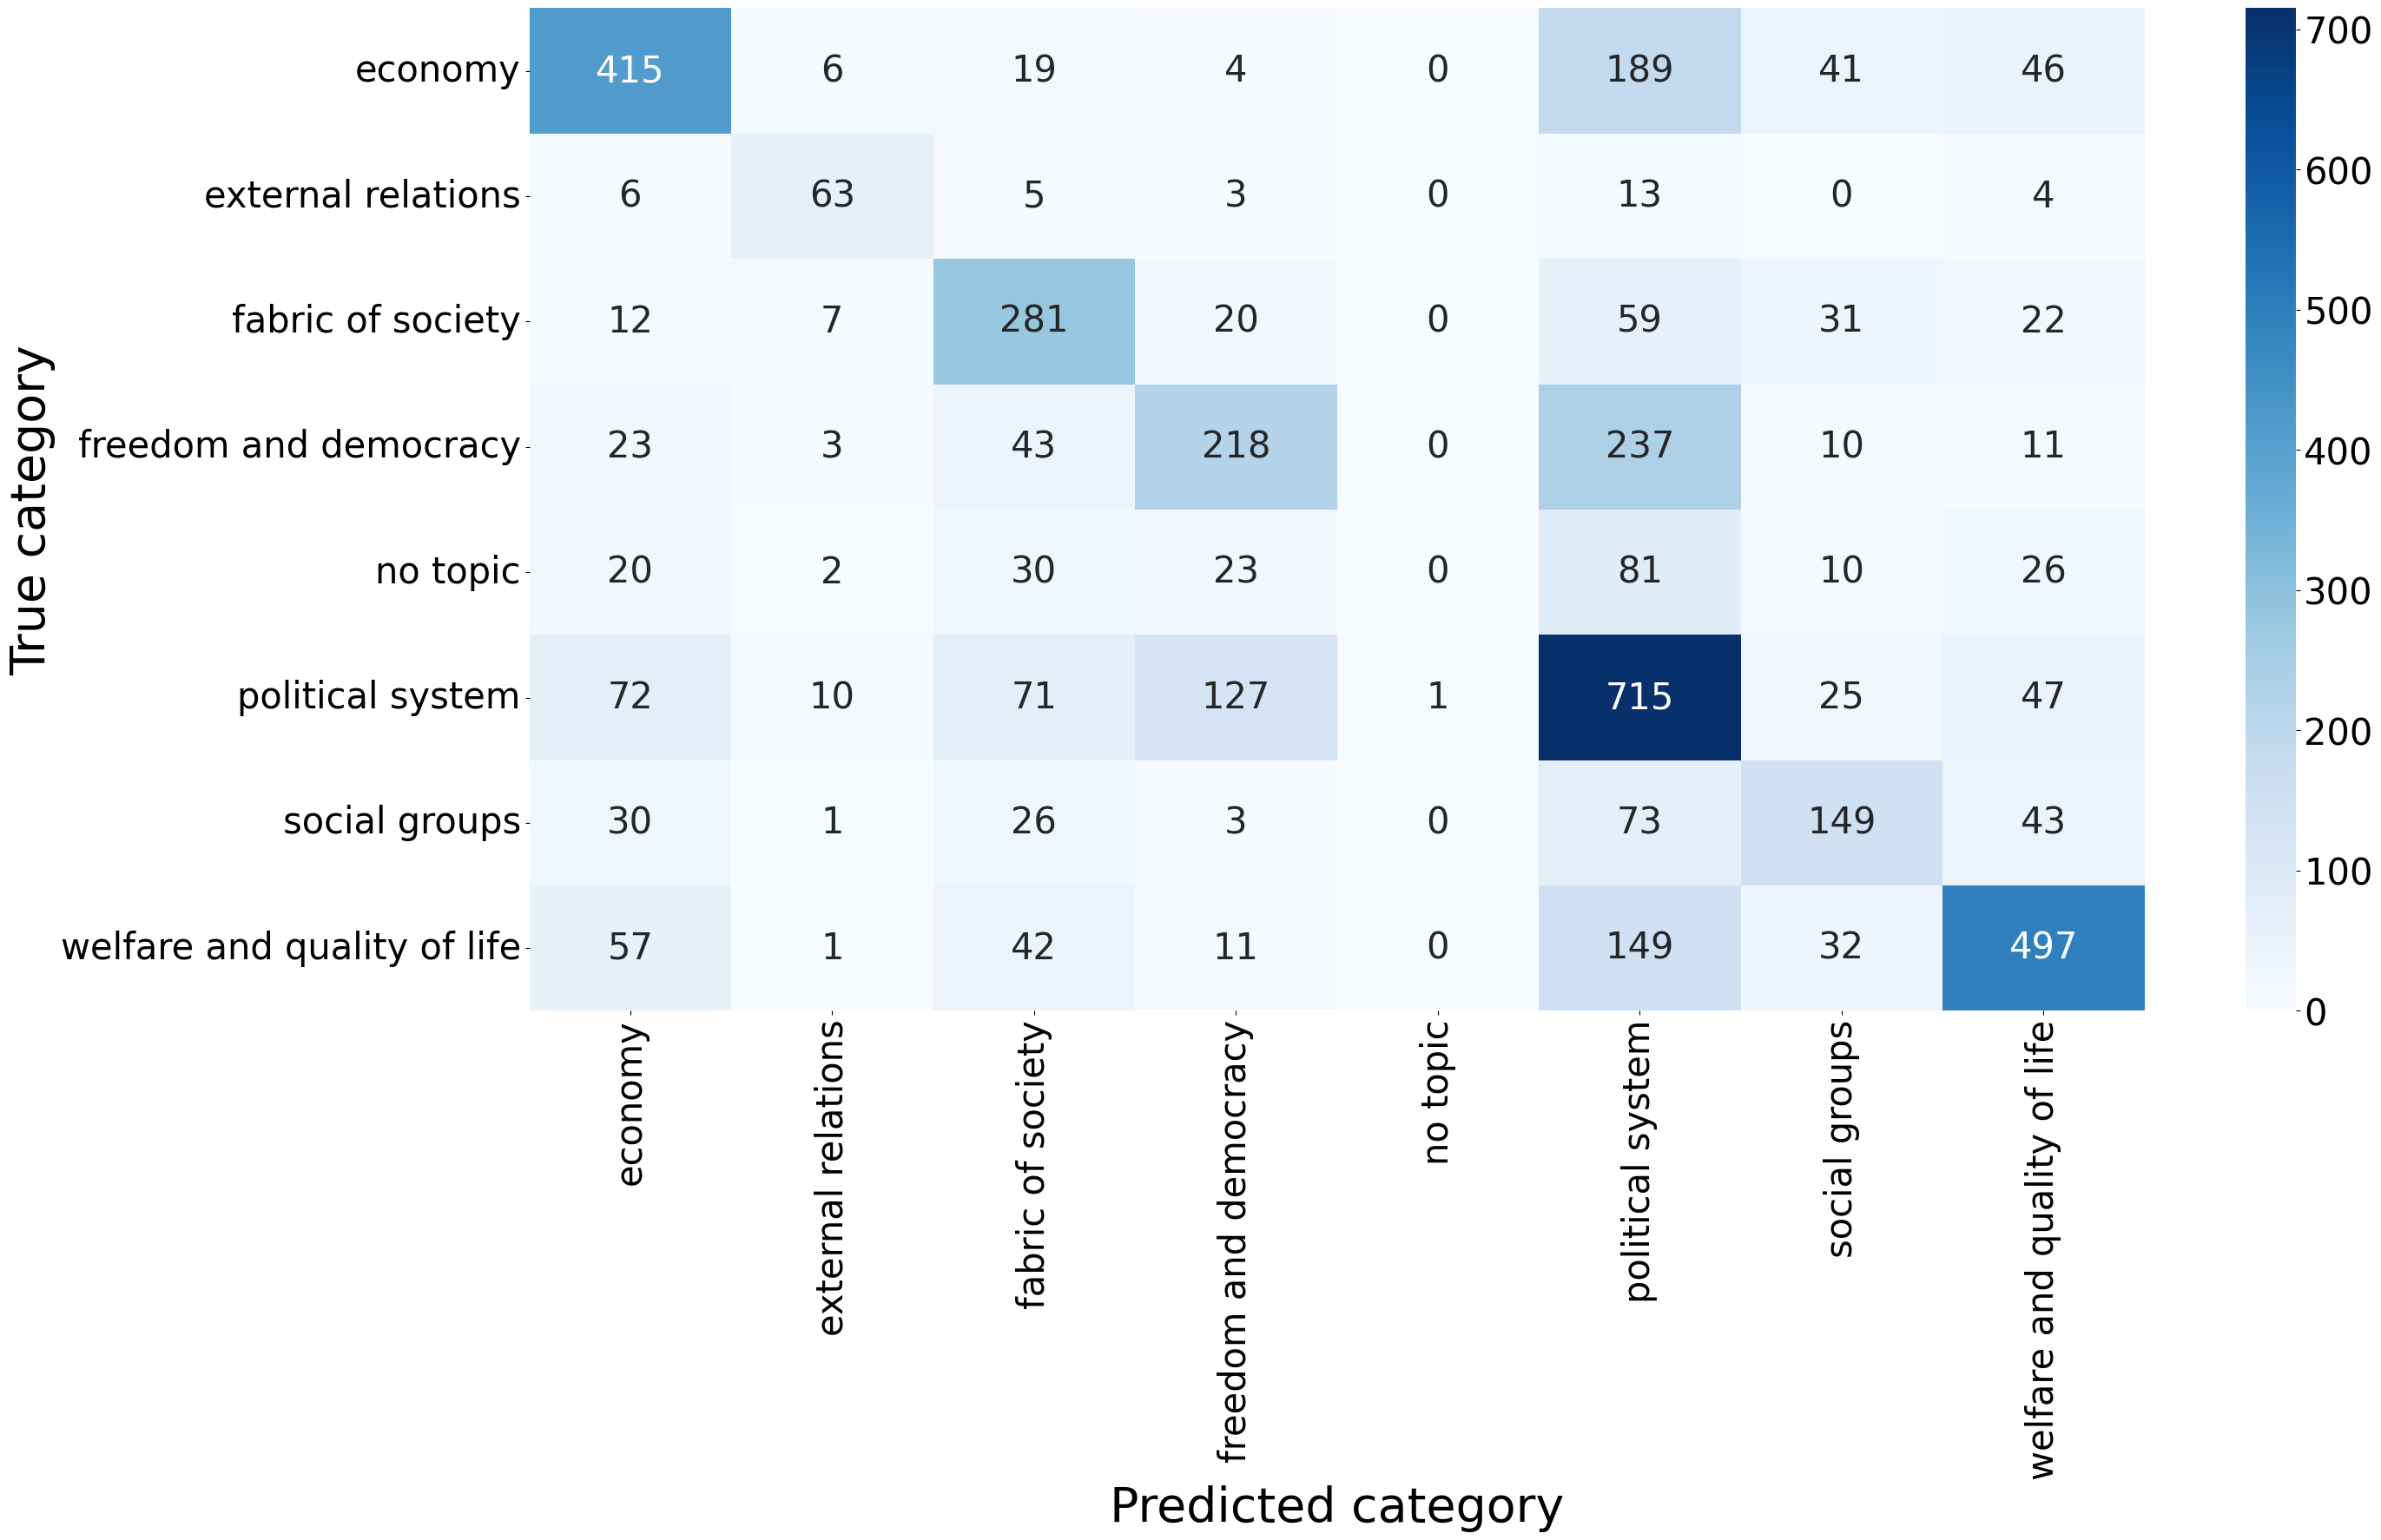

In [ ]:
classification_report_target = evaluation_per_category(Y_target, Y_pred_target, data_description ="target",  path_results = path_results, figsize=(30,15))

# Experiment 3:
**Model:** fine-tuend BERT (on English data from Manifest project, version 2018-2)   
**Testing data:** data from Manifest project, version 2022-1 with date>2028  
**Result:** Transfer across time works well 

In [ ]:
# load data
path_file = './drive/MyDrive/Paper BERT/data/multilingual_data_2022-1.csv'
data_2022 = pd.read_csv(path_file,  index_col=None)

# ensure variables as string
data_2022['topic_8'] = data_2022['topic_8'].astype(str) # categories
data_2022['text'] = data_2022['text'].astype(str) # topic

data_2022.head(3)

,countryname,text,language,code,document_index,date,topic_8
0,Sweden,Miljöpartiet de Gröna går till val på en polit...,swedish,408.0,81,200609,economy
1,Sweden,"fler företag,",swedish,402.0,81,200609,economy
2,Sweden,"levande landsbygd,",swedish,301.0,81,200609,political system


Select English speaking countries: Australia, Canada, Ireland, New Zealand, South Africa, the United Kingdom (UK) and the United States (USA) and language english (e.g. in Canada French is also official national language)

In [ ]:
countries = ["Australia", "Canada", "Ireland", "New Zealand", "United Kingdom", "United States", "South Africa"]
data_2022 = data_2022.loc[data_2022['countryname'].isin(countries), :]
data_2022 = data_2022.loc[data_2022['language'] =="english", :]
print(data_2022.shape)
data_2022.head(3) 

(158601, 7)


,countryname,text,language,code,document_index,date,topic_8
779052,United Kingdom,Our aim: To make Britain the world's foremost ...,english,411.0,31,199705,economy
779053,United Kingdom,The problem: This country's education has been...,english,506.0,31,199705,welfare and quality of life
779054,United Kingdom,"Standards are too low, especially in core skil...",english,506.0,31,199705,welfare and quality of life


In [ ]:
# no data for 2018
data_2022[data_2022["date"]==201800]

,countryname,text,language,code,document_index,date,topic_8


In [ ]:
data_future = data_2022[data_2022["date"]>201800]
print(data_future.shape)

X_future = data_future['text'] 
Y_future = data_future['topic_8']

(27764, 7)


In [ ]:
# creat numeric Y
Y_future_numeric = [dic_y_mapping_inverse[y_test] for y_test in Y_future]
Y_future_numeric = np.array(Y_future_numeric, dtype= 'object')
Y_future_numeric

array([6, 6, 5, ..., 1, 0, 4], dtype=object)

In [ ]:
# create data set
dataset = {'future':Dataset.from_dict({'label':Y_future_numeric,'text':X_future})}
dataset_future = DatasetDict(dataset)
encoded_dataset_future = dataset_future.map(preprocess_function, batched=True)

Map:   0%|          | 0/27764 [00:00<?, ? examples/s]

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset_future["future"])

{'eval_loss': 0.9941226243972778,
 'eval_f1': 0.5707065686640034,
 'eval_runtime': 105.8536,
 'eval_samples_per_second': 262.287,
 'eval_steps_per_second': 16.4,
 'epoch': 3.0}

In [ ]:
Y_pred_future, Y_future_classes = predict_BERT(encoded_dataset_future["future"], dic_y_mapping, Y_future_numeric)

evaluation_future = evaluation_table(Y_future,Y_pred_future, domain= 'cross-domain', data_description ="future")
evaluation_future.to_csv(path_results +'/evaluation_future.csv')
evaluation_future

,metric,score,domain,data
0,Accuracy,0.684087,cross-domain,future
1,F1 score (macro),0.570707,cross-domain,future


Accuracy: 0.68
Detail:


<Figure size 640x480 with 0 Axes>

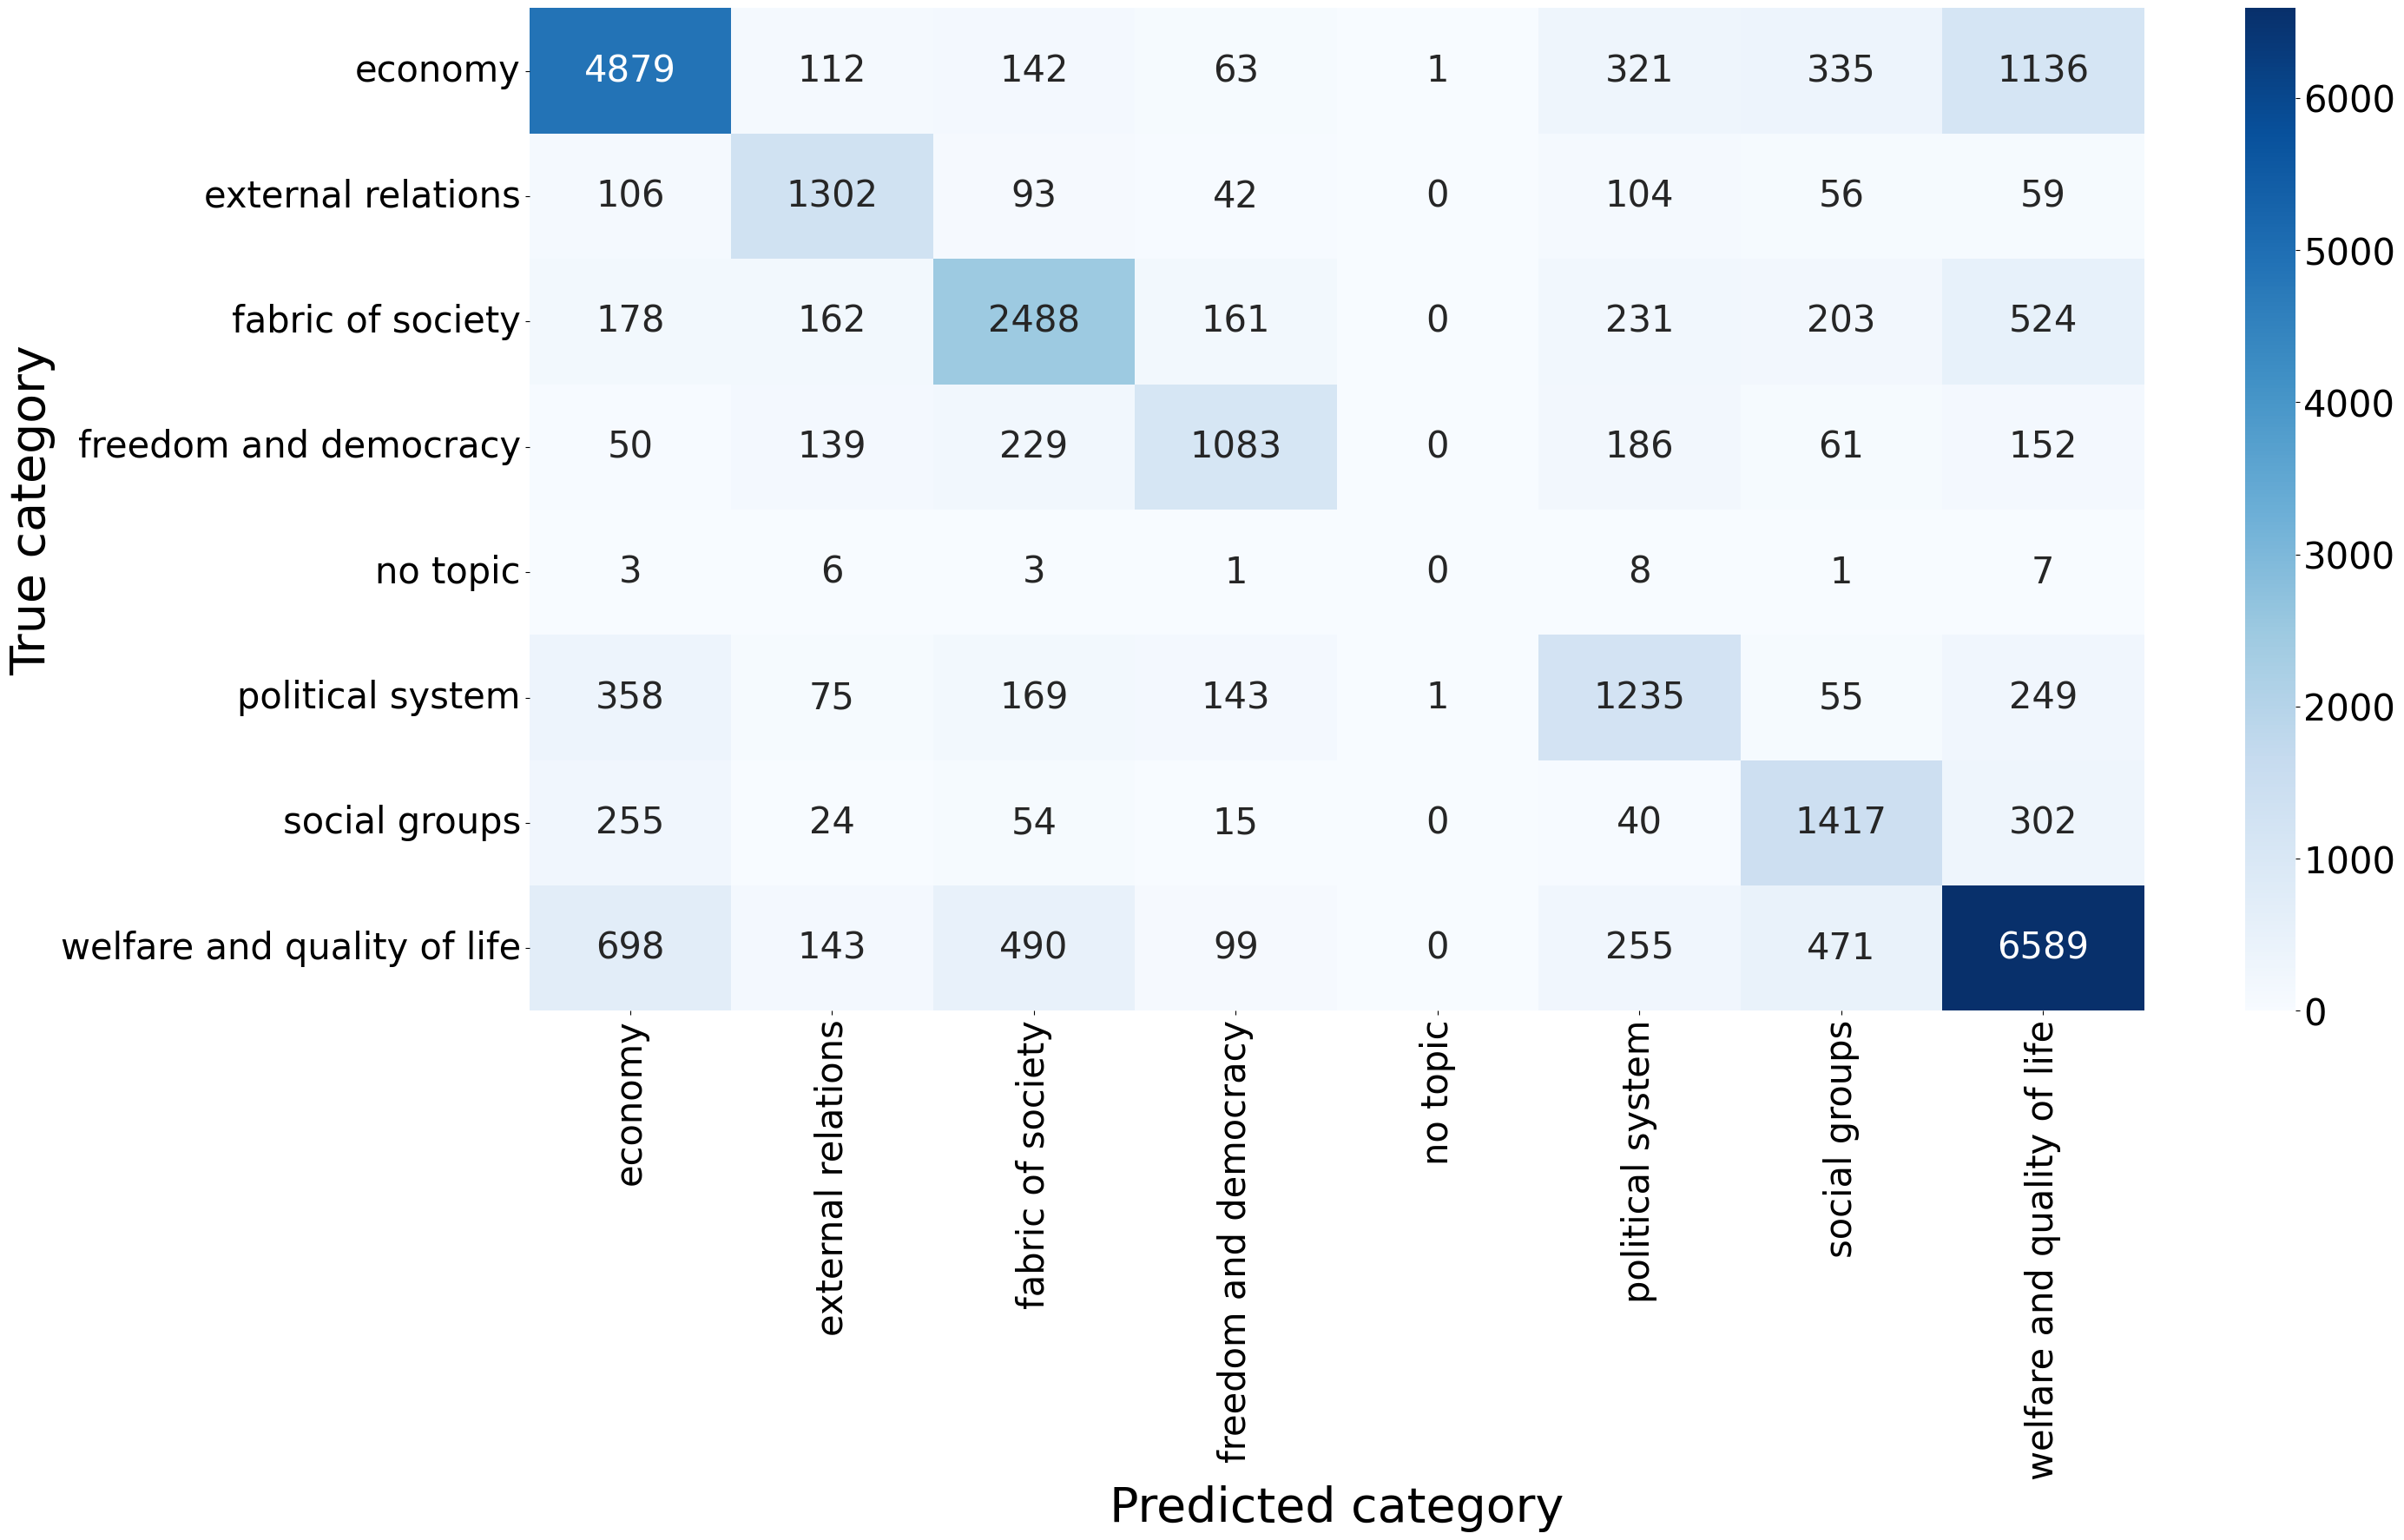

In [ ]:
classification_report_future = evaluation_per_category(Y_future, Y_pred_future, data_description ="future", path_results = path_results, figsize=(30,15))

### Overview results Exp 1-3

In [ ]:
eval_metrics = pd.concat([evaluation_training, evaluation_testing, evaluation_target, evaluation_future])
eval_metrics.reset_index(drop = True, inplace = True)
eval_metrics.to_csv(path_results + '/eval_metrics.csv')
eval_metrics

,metric,score,domain,data
0,Accuracy,0.872852,within-domain,training
1,F1 score (macro),0.763882,within-domain,training
2,Accuracy,0.697695,within-domain,testing
3,F1 score (macro),0.584098,within-domain,testing
4,Accuracy,0.561345,cross-domain,target
5,F1 score (macro),0.504583,cross-domain,target
6,Accuracy,0.684087,cross-domain,future
7,F1 score (macro),0.570707,cross-domain,future


In [ ]:
classification_report = pd.concat([classification_report_testing, classification_report_target, classification_report_future])
classification_report.to_csv(path_results + '/classification_report_' + '.csv', index=True)
classification_report

,precision,recall,f1-score,support,data
economy,0.741002,0.760442,0.750596,2897.0,testing
external relations,0.761580,0.771034,0.766278,725.0,testing
fabric of society,0.662853,0.682104,0.672340,1274.0,testing
freedom and democracy,0.612284,0.563604,0.586937,566.0,testing
no topic,0.333333,0.009804,0.019048,102.0,testing
political system,0.583832,0.491597,0.533759,1190.0,testing
social groups,0.579913,0.583993,0.581946,1137.0,testing
welfare and quality of life,0.741430,0.783488,0.761879,3561.0,testing
economy,0.653543,0.576389,0.612546,720.0,target
external relations,0.677419,0.670213,0.673797,94.0,target


# Expeirment 4: Evaluation per country

In [ ]:
country_eval = pd.DataFrame(index =  ["Accuracy", "F1 macro", "Obsevations", "Number of no topics", "Percentage no topics"])
for i in country.unique():
  country_eval[i] = evaluation_country(i, country_test, Y_test_classes, Y_pred_testing)

country_eval.to_csv(path_results + '/country_eval_test_set.csv')
country_eval

,United Kingdom,Ireland,United States,Canada,Australia,New Zealand,South Africa
Accuracy,0.669111,0.666013,0.633987,0.636646,0.754970,0.729930,0.750000
F1 macro,0.550751,0.564998,0.551917,0.610049,0.627302,0.585356,0.737385
Obsevations,2182.000000,2548.000000,1071.000000,322.000000,1861.000000,2840.000000,628.000000
Number of no topics,20.000000,41.000000,23.000000,0.000000,6.000000,12.000000,0.000000
Percentage no topics,0.010000,0.020000,0.020000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Confusion metric for different countries
for i in country.unique():
  print(len(Y_test_classes[country_test == i]))
  classification_report_per_country_test_set = evaluation_per_category(Y_test_classes[country_test == i], np.array(Y_pred_testing)[country_test == i], data_description = i+'_random_test_split', path_results = path_results, figsize=(30,15))

Output hidden; open in https://colab.research.google.com to view.

# Packages

In [ ]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

transformers==4.27.4
pandas==1.4.4
numpy==1.22.4
seaborn==0.12.2


In [ ]:
!pip list -v

Package                       Version              Location                               Installer
----------------------------- -------------------- -------------------------------------- ---------
absl-py                       1.4.0                /usr/local/lib/python3.9/dist-packages pip
aiohttp                       3.8.4                /usr/local/lib/python3.9/dist-packages pip
aiosignal                     1.3.1                /usr/local/lib/python3.9/dist-packages pip
alabaster                     0.7.13               /usr/local/lib/python3.9/dist-packages pip
albumentations                1.2.1                /usr/local/lib/python3.9/dist-packages pip
altair                        4.2.2                /usr/local/lib/python3.9/dist-packages pip
anyio                         3.6.2                /usr/local/lib/python3.9/dist-packages pip
appdirs                       1.4.4                /usr/local/lib/python3.9/dist-packages pip
argon2-cffi                   21.3.0            

**Resources:**
* https://huggingface.co/docs/transformers/tasks/sequence_classification
* https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb#scrollTo=545PP3o8IrJV